In [6]:
import h2o
import pandas as pd
import matplotlib.pyplot as plt
from h2o.estimators import H2OGeneralizedLinearEstimator, H2OGradientBoostingEstimator, H2ORandomForestEstimator, H2ODeepLearningEstimator
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

import scipy.stats as ss
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import recall_score

In [8]:
data = pd.read_csv("Mall_Customers.csv")

In [9]:
data

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [12]:
data.replace({"Female":1,"Male":0}, inplace=True) # Debido a que tiene valores na

In [13]:
ss.shapiro(data['Genre'])

ShapiroResult(statistic=0.6311767101287842, pvalue=1.4682888850168124e-20)

In [15]:
ss.shapiro(data['Age'])

ShapiroResult(statistic=0.9516184329986572, pvalue=2.7109526854474097e-06)

In [16]:
ss.shapiro(data['Annual Income (k$)'])

ShapiroResult(statistic=0.9783905148506165, pvalue=0.003537340322509408)

In [17]:
ss.shapiro(data['Spending Score (1-100)'])

ShapiroResult(statistic=0.9694603085517883, pvalue=0.00024227304675150663)

Con una confianza del 95%, las variables todas las variables numéricas
no se aproximan a una distribución normal, pues el pvalor < 5%

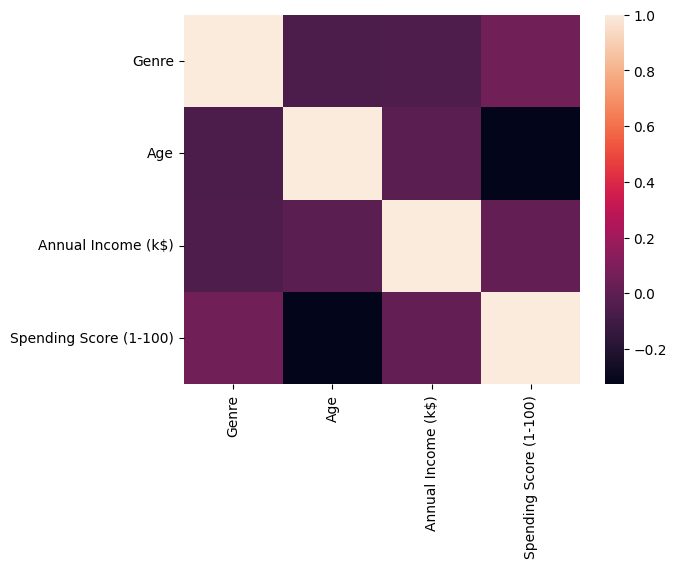

In [23]:
sns.heatmap(data.loc[:,['Genre','Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr(method = "pearson"))
plt.show()

In [22]:
data.loc[:,['Genre','Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr(method = "pearson")

,Genre,Age,Annual Income (k$),Spending Score (1-100)
Genre,1.000000,-0.060867,-0.056410,0.058109
Age,-0.060867,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.056410,-0.012398,1.000000,0.009903
Spending Score (1-100),0.058109,-0.327227,0.009903,1.000000


Prueba de Correlación:
- Ho: no existe correlación entre las variables
- Ha: existe correlación entre las variables

Con un nivel de confianza del 95%, se rechaza la Ho, pues el pvalor < 5%,

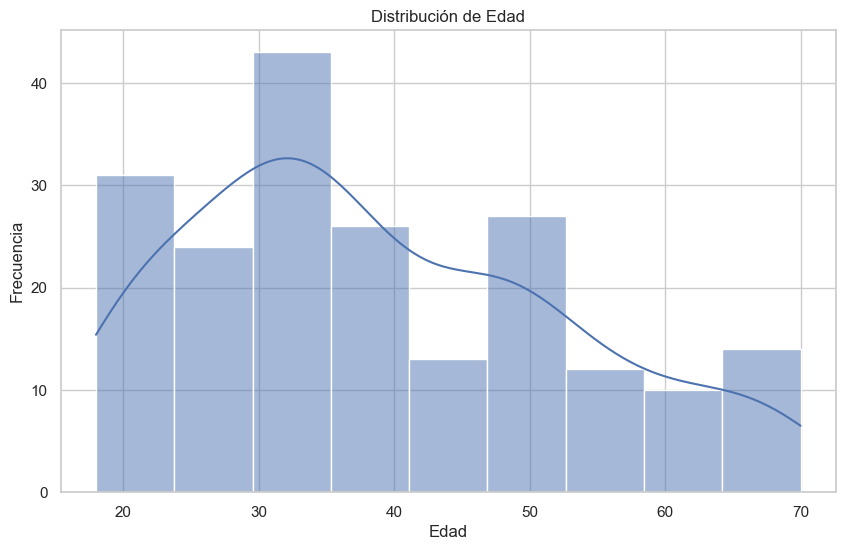

In [61]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Age'], kde=True)
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

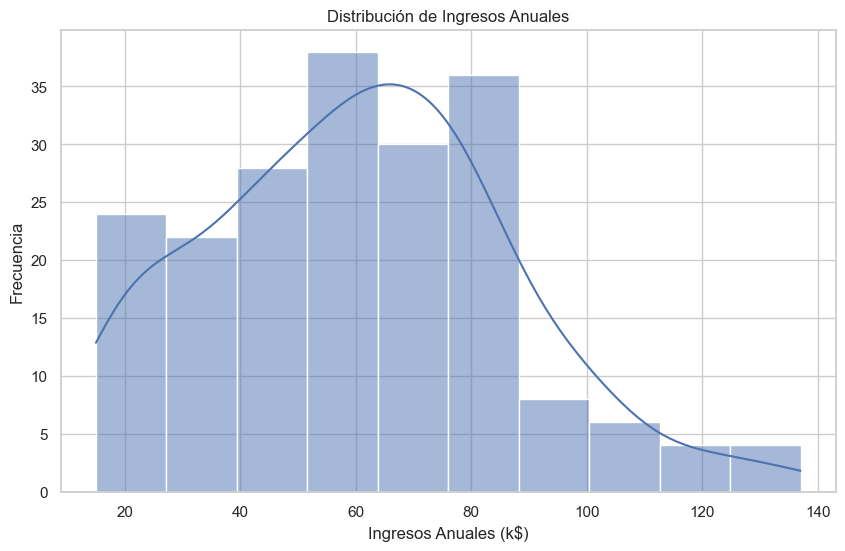

In [62]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Annual Income (k$)'], kde=True)
plt.title('Distribución de Ingresos Anuales')
plt.xlabel('Ingresos Anuales (k$)')
plt.ylabel('Frecuencia')
plt.show()

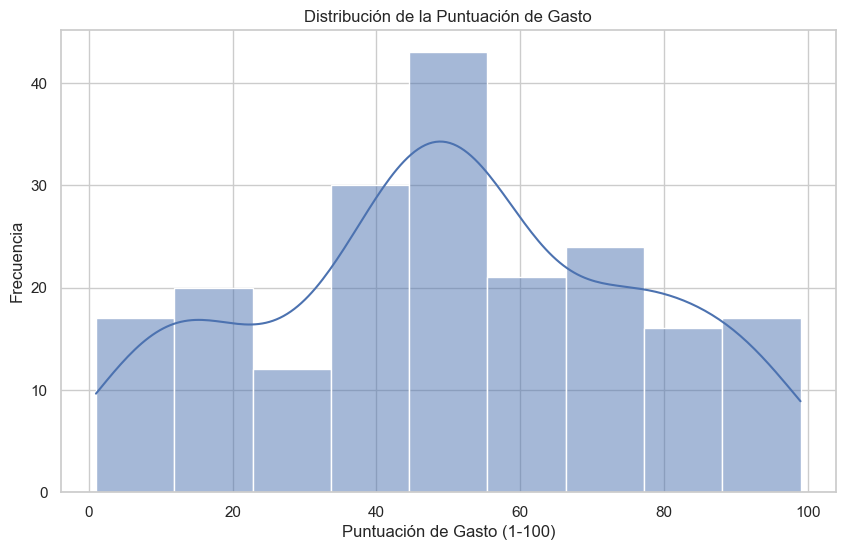

In [63]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Spending Score (1-100)'], kde=True)
plt.title('Distribución de la Puntuación de Gasto')
plt.xlabel('Puntuación de Gasto (1-100)')
plt.ylabel('Frecuencia')
plt.show()

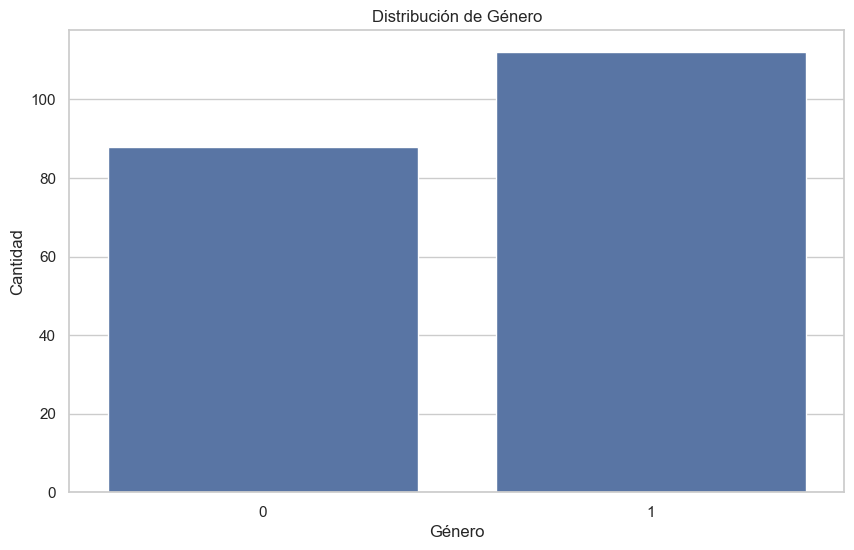

In [64]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Genre', data=data)
plt.title('Distribución de Género')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.show()

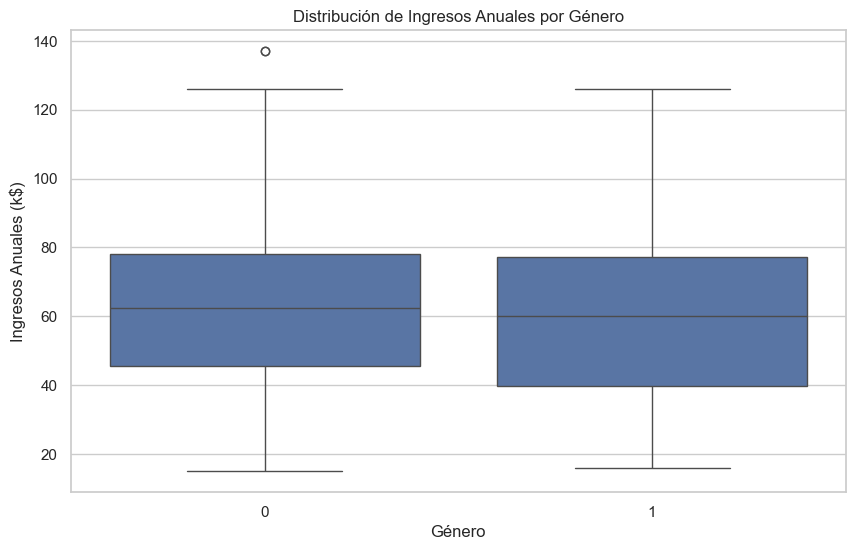

In [65]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Annual Income (k$)', data=data)
plt.title('Distribución de Ingresos Anuales por Género')
plt.xlabel('Género')
plt.ylabel('Ingresos Anuales (k$)')
plt.show()


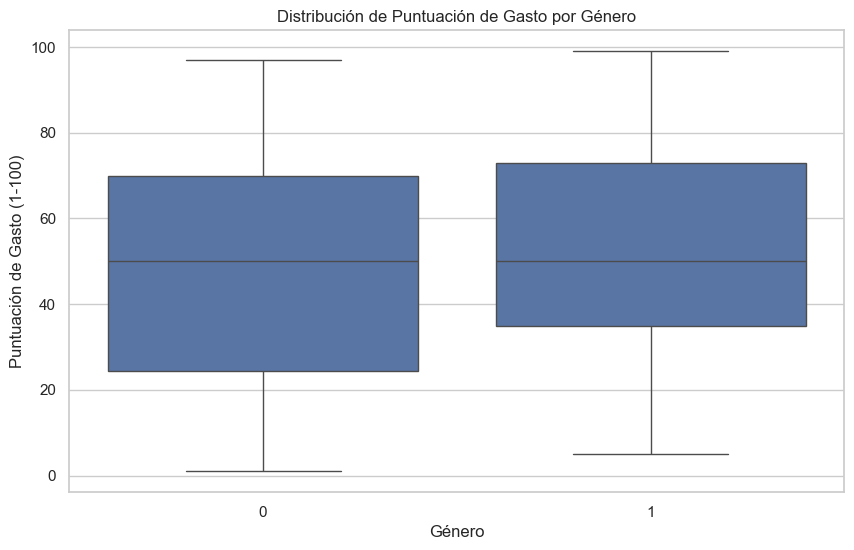

In [66]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Spending Score (1-100)', data=data)
plt.title('Distribución de Puntuación de Gasto por Género')
plt.xlabel('Género')
plt.ylabel('Puntuación de Gasto (1-100)')
plt.show()

In [25]:
df=data[['Genre','Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

In [26]:
df

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40
...,...,...,...,...
195,1,35,120,79
196,1,45,126,28
197,0,32,126,74
198,0,32,137,18


In [27]:
df.to_csv('data.csv', index=False)

In [45]:
import h2o
from h2o.estimators import H2OKMeansEstimator
h2o.init(max_mem_size="8G")
data_h2o = h2o.import_file(
                path   = "data.csv",
                header = 1,
                sep    = ",",
                destination_frame = "datos_h2o"
            )
predictors = ['Genre','Age', 'Annual Income (k$)', 'Spending Score (1-100)']

train, test = data_h2o.split_frame(ratios=[.9], seed=1234)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,5 hours 51 mins
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_carlo_3s3qmj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.501 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [46]:
kmeans3 = H2OKMeansEstimator(k=3,
                            standardize=True,
                            seed=1234)
kmeans3.train(x=predictors,
            training_frame=train,
            validation_frame=test)
prediction_train3 = kmeans3.predict(train)
prediction_test3 = kmeans3.predict(test)

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


In [47]:
kmeans4 = H2OKMeansEstimator(k=4,
                            standardize=True,
                            seed=1234)
kmeans4.train(x=predictors,
            training_frame=train,
            validation_frame=test)
prediction_train4 = kmeans4.predict(train)
prediction_test4 = kmeans4.predict(test)

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


In [48]:
kmeans5 = H2OKMeansEstimator(k=5,
                            standardize=True,
                            seed=1234)
kmeans5.train(x=predictors,
            training_frame=train,
            validation_frame=test)
prediction_train5 = kmeans5.predict(train)
prediction_test5 = kmeans5.predict(test)

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


In [49]:
kmeans6 = H2OKMeansEstimator(k=6,
                            standardize=True,
                            seed=1234)
kmeans6.train(x=predictors,
            training_frame=train,
            validation_frame=test)
prediction_train6 = kmeans6.predict(train)
prediction_test6 = kmeans6.predict(test)

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


In [59]:
prediction_train

predict
2
2
2
2
2
0
2
0
0
2


In [50]:
train["segmento3"] = prediction_train3["predict"].asfactor()
train["segmento4"] = prediction_train4["predict"].asfactor()
train["segmento5"] = prediction_train5["predict"].asfactor()
train["segmento6"] = prediction_train6["predict"].asfactor()
train.head()

Genre,Age,Annual Income (k$),Spending Score (1-100),segmento3,segmento4,segmento5,segmento6
0,19,15,39,2,2,2,3
0,21,15,81,2,2,2,2
1,20,16,6,2,2,2,2
1,31,17,40,2,2,2,2
1,22,17,76,2,2,2,2
1,35,18,6,0,0,2,5
1,23,18,94,2,2,2,2
0,64,19,3,0,0,0,0
0,67,19,14,0,0,0,0
1,35,19,99,2,2,2,2


In [51]:
train.group_by(['segmento3']).count(na ="all").get_frame()

segmento3,nrow
0,77
1,41
2,59


In [52]:
train.group_by(['segmento4']).count(na ="all").get_frame()

segmento4,nrow
0,57
1,37
2,55
3,28


In [53]:
train.group_by(['segmento5']).count(na ="all").get_frame()

segmento5,nrow
0,42
1,36
2,43
3,36
4,20


In [54]:
train.group_by(['segmento6']).count(na ="all").get_frame()

segmento6,nrow
0,27
1,36
2,38
3,26
4,15
5,35


In [55]:
train.group_by(['segmento3']).mean(['Genre','Age', 'Annual Income (k$)', 'Spending Score (1-100)'], na="all").get_frame()

segmento3,mean_Genre,mean_Age,mean_Annual Income (k$),mean_Spending Score (1-100)
0,0.532468,51.6753,57.8961,34.2338
1,0.585366,33.4146,89.2439,76.4146
2,0.559322,24.6441,44.8305,54.322


In [56]:
train.group_by(['segmento4']).mean(['Genre','Age', 'Annual Income (k$)', 'Spending Score (1-100)'], na="all").get_frame()

segmento4,mean_Genre,mean_Age,mean_Annual Income (k$),mean_Spending Score (1-100)
0,0.596491,53.5965,48.5614,40.807
1,0.567568,32.8378,86.4865,81.5135
2,0.6,24.9273,42.5455,57.6909
3,0.357143,41.5,87.6429,16.3929


In [57]:
train.group_by(['segmento5']).mean(['Genre','Age', 'Annual Income (k$)', 'Spending Score (1-100)'], na="all").get_frame()

segmento5,mean_Genre,mean_Age,mean_Annual Income (k$),mean_Spending Score (1-100)
0,0.666667,56.619,46.5952,41.5
1,0.555556,32.6389,86.9722,82.1667
2,0.697674,24.7674,36.6279,60.2558
3,0,37.9722,68.4722,29.8056
4,1,40.9,81.7,30.45


In [58]:
train.group_by(['segmento6']).mean(['Genre','Age', 'Annual Income (k$)', 'Spending Score (1-100)'], na="all").get_frame()

segmento6,mean_Genre,mean_Age,mean_Annual Income (k$),mean_Spending Score (1-100)
0,0,57.7407,56.037,37.037
1,0.555556,32.6389,86.9722,82.1667
2,0.789474,25.0526,37.6842,61.9474
3,0,28.3077,59.5385,34.0769
4,0.866667,40.0667,93.5333,22.8
5,1,50.8571,49.5714,40.9714
